In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.ticker as tick
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet
from xgboost import plot_importance, plot_tree
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmspe
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import math
mpl.style.use('ggplot')
import warnings 
warnings.filterwarnings("ignore")

In [2]:
sales_df = pd.read_csv('sales.csv')
store_df = pd.read_csv('store.csv')

In [3]:
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Descriptive Statistics - Sales Data

In [5]:
#Number of Data points in Sales
sales_df.shape

(1017209, 9)

In [6]:
## Features in Sales
sales_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [7]:
## Data types of the features along with the not null counts in sales dataframe
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


From the above information we can see that there are no missing values in the sales_data. It has 1017209 rows and 9 features. Sales is the target column which indicates the historical sales across different stores on each day and we are tasked with predicting the daily sales for up to six weeks in advance.

- Numeric Columns
    - Store
    - DayOfWeek
    - Sales
    - Customers
    - Open
    - Promo
    - SchoolHoliday <br> </br>    
- Categorical Columns
    - StateHoliday
    
There are no missing values in Sales Data

In [8]:
#target variable is the Sales 
print("The data type of target variable is :",sales_df['Sales'].dtype)

The data type of target variable is : int64


In [9]:
## More Description of the data in sales
sales_df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00,1017209.00
mean,558.43,4.00,5773.82,633.15,0.83,0.38,0.18
std,321.91,2.00,3849.93,464.41,0.38,0.49,0.38
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,280.00,2.00,3727.00,405.00,1.00,0.00,0.00
50%,558.00,4.00,5744.00,609.00,1.00,0.00,0.00
75%,838.00,6.00,7856.00,837.00,1.00,1.00,0.00
max,1115.00,7.00,41551.00,7388.00,1.00,1.00,1.00


Max number of Sales across different stores is 41,551 and minimum number of sales is 0 (most probably the store is closed).

In [10]:
#checking missing values after filling
sales_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

There are no missing values in Sales Data

## Descriptive Statisics - Store Data

In [11]:
## Number of Data Points in Store
store_df.shape

(1115, 10)

In [12]:
## Featues in Store
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [13]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Store data contains the store information like Store Type, Assortment type, distance at which the competitor is located and also if the store is running a promocode . It has 1115 rows and 10 features.

- Numeric Columns
    - Store
    - CompetitionDistance
    - CompetitionOpenSinceMonth
    - CompetitionOpenSinceYear
    - Promo2
    - Promo2SinceWeek <br> </br>

- Categorical Columns
    - StoreType
    - Assortment
    - PromoInterval

In [14]:
## More Description of the data in sales
store_df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00,1112.00,761.00,761.00,1115.00,571.00,571.00
mean,558.00,5404.90,7.22,2008.67,0.51,23.60,2011.76
std,322.02,7663.17,3.21,6.20,0.50,14.14,1.67
min,1.00,20.00,1.00,1900.00,0.00,1.00,2009.00
25%,279.50,717.50,4.00,2006.00,0.00,13.00,2011.00
50%,558.00,2325.00,8.00,2010.00,1.00,22.00,2012.00
75%,836.50,6882.50,10.00,2013.00,1.00,37.00,2013.00
max,1115.00,75860.00,12.00,2015.00,1.00,50.00,2015.00


There are 1115 unique stores. Competitor store is located at the maximum distance of 75860 meters. The nearest store is located at the distance of 20meters. Competitior store started in the year 2008. Stores started using promo codes from 2011.

In [15]:
## Finding the missing values
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

## Handling missing values

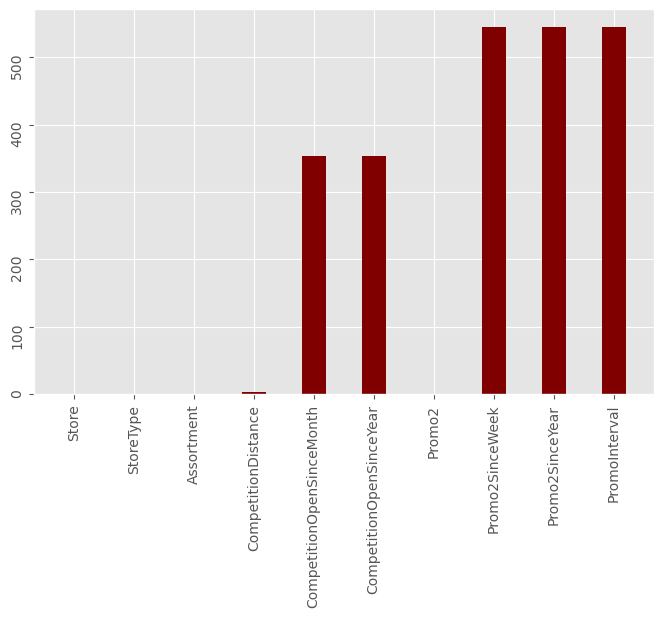

In [16]:
#plot for Missing values of all features in Store data
store_fig = plt.figure(figsize = (8, 5))
plt.bar(store_df.columns, store_df.isnull().sum(), color ='maroon',width=0.4)
plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=10,rotation=90)
plt.show()

In [17]:
#Percentage of Missing Values in Storedata
pd.set_option('display.max_columns', 20)
def display_data_info(data):  
    per_data=[]
    perc_null_vals=0
    # Print the number of null values in the data and the percentage of null values
    print("FEATURES WITH NULL VALUES\n")
    rows=data.shape[0]
    for col in data.columns:
        null_values = data[col].isnull().sum() # Calculate the number of null values  

    # If the null values > 0 print the column, number of null values and the percentage of null values
        if null_values > 0:
            perc_null_vals = float(null_values)*100/rows
            per_data.append(perc_null_vals)
            print("FEATURE: {}".format(col))
            print("NULL VALUES COUNT: {}".format(null_values))
            print("PERCENTAGE VALUES COUNT: {:.3f}%".format(perc_null_vals))
            print()
            
    return perc_null_vals
display_data_info(sales_df) # As there are no null values in sales data frame, it will print 0 percent
print("Null values in store data frame")
print("****************************************")
per_store=display_data_info(store_df)

FEATURES WITH NULL VALUES

Null values in store data frame
****************************************
FEATURES WITH NULL VALUES

FEATURE: CompetitionDistance
NULL VALUES COUNT: 3
PERCENTAGE VALUES COUNT: 0.269%

FEATURE: CompetitionOpenSinceMonth
NULL VALUES COUNT: 354
PERCENTAGE VALUES COUNT: 31.749%

FEATURE: CompetitionOpenSinceYear
NULL VALUES COUNT: 354
PERCENTAGE VALUES COUNT: 31.749%

FEATURE: Promo2SinceWeek
NULL VALUES COUNT: 544
PERCENTAGE VALUES COUNT: 48.789%

FEATURE: Promo2SinceYear
NULL VALUES COUNT: 544
PERCENTAGE VALUES COUNT: 48.789%

FEATURE: PromoInterval
NULL VALUES COUNT: 544
PERCENTAGE VALUES COUNT: 48.789%



In [18]:
# No of stores which are missing PromoInterval
stores_with_noPromoInt = store_df['Store'][store_df['PromoInterval'].isna()].to_list()
no_promo_int = store_df['Store'][store_df['PromoInterval'].isna()].nunique()
print("{} stores have missing PromoInterval".format(no_promo_int))

# No of stores which are missing Promo2SinceWeek and Promo2SinceWeek.
stores_with_noPromoWeek = store_df['Store'][store_df['Promo2SinceWeek'].isna()].to_list()
no_promo_week = store_df['Store'][store_df['Promo2SinceWeek'].isna()].nunique()
print("{} stores have missing Promo2SinceWeek".format(no_promo_week))

# No of stores which are missing Promo2SinceWeek and Promo2SinceYear.
stores_with_noPromoYear = store_df['Store'][store_df['Promo2SinceYear'].isna()].to_list()
no_promo_year = store_df['Store'][store_df['Promo2SinceYear'].isna()].nunique()
print("{} stores have missing Promo2SinceYear".format(no_promo_year))

544 stores have missing PromoInterval
544 stores have missing Promo2SinceWeek
544 stores have missing Promo2SinceYear


In [19]:
#Checking if Promo2 is available for these stores
print(store_df['Promo2'][store_df['Store'].isin(stores_with_noPromoInt)].value_counts())
print(store_df['Promo2'][store_df['Store'].isin(stores_with_noPromoWeek)].value_counts())
print(store_df['Promo2'][store_df['Store'].isin(stores_with_noPromoYear)].value_counts())

0    544
Name: Promo2, dtype: int64
0    544
Name: Promo2, dtype: int64
0    544
Name: Promo2, dtype: int64


We can see that the Promo2 column values (0 if no promo2 and 1 if store is running promo) are 0 for all the stores where PromoInterval is missing which means that these store are not running a promocode. Hence we fill NaN in PromoInterval with 0.

In [20]:
store_df['PromoInterval'] = np.where(store_df['PromoInterval'].isna(),0,store_df['PromoInterval'])
store_df['Promo2SinceWeek']= store_df['Promo2SinceWeek'].fillna(0)
store_df['Promo2SinceYear']= store_df['Promo2SinceYear'].fillna(0)
print(store_df.isnull().sum())
store_df.head()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [21]:
#Filling Na of CompetitionDistance with mean value
store_df['CompetitionDistance']=store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].mean())

#Filling Na of CompetitionOpenSinceMonth and CompetitionOpenSinceYear with most frequent value.
store_df['CompetitionOpenSinceMonth']= store_df['CompetitionOpenSinceMonth'].fillna(store_df['CompetitionOpenSinceMonth'].mode().iloc[0])
store_df['CompetitionOpenSinceYear']= store_df['CompetitionOpenSinceYear'].fillna(store_df['CompetitionOpenSinceYear'].mode().iloc[0])
store_df.isna().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

## Exploratory Data Analysis

In [22]:
#Why Sales are 0 in some cases? Is the store opened?
zero_sales = sales_df[sales_df['Sales'] == 0]
zero_sales['Open'].value_counts()

0    172817
1        54
Name: Open, dtype: int64

Mostly, sales are 0 when the store is closed.

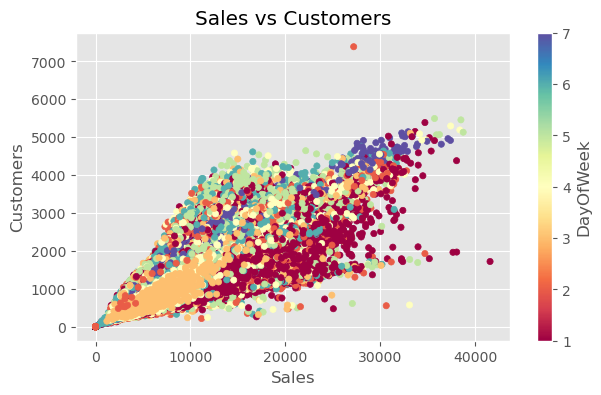

In [23]:
sales_df.plot(kind='scatter',x='Sales',y='Customers',figsize =(7,4),c='DayOfWeek',cmap ='Spectral')
plt.title('Sales vs Customers')
plt.xlabel('Sales')
plt.ylabel('Customers')
plt.show()

#### Analysis on Target column Sales

In [24]:
#Removing records where sales are 0 for better analysis
sales_df_filt = sales_df[sales_df['Sales'] != 0]

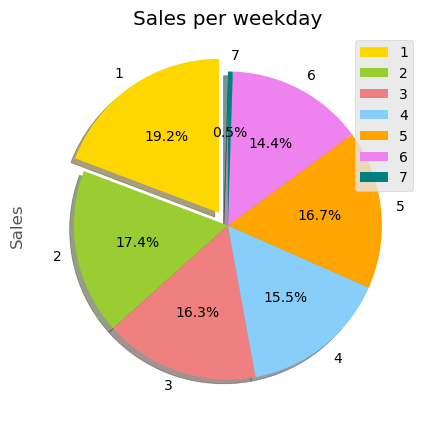

In [25]:
#Total Sales per week day
sales_df_filt[['Sales', 'DayOfWeek']].groupby('DayOfWeek').sum().reset_index()['Sales'].plot(
    kind='pie',
    figsize=(15,5),
    autopct='%1.1f%%',
    colors=['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','orange','violet','teal'],
    explode=[0.1,0,0,0,0,0,0],startangle=90,shadow=True,
labels=[1,2,3,4,5,6,7])
plt.title('Sales per weekday')
plt.legend(labels=[1,2,3,4,5,6,7],loc='upper right')
plt.show()

The majority of sales take place during the week. Sales are very less on Sundays.

In [26]:
#Further Analysis on why the sales are less on Sundays
day7_sales = sales_df[sales_df['DayOfWeek']==7]
zero_sales = day7_sales[['Sales','Open']].value_counts().iloc[0]
print("{:.2f}% of the time the store is closed on Sundays. Hence the sales are very less during sundays".format(zero_sales/len(day7_sales)*100))

97.52% of the time the store is closed on Sundays. Hence the sales are very less during sundays


In [27]:
#Average Sales per week day
sale_day= sales_df_filt.groupby(['DayOfWeek'])['Sales'].mean().reset_index(name='Average_sales_per_weekday')
sale_day

,DayOfWeek,Average_sales_per_weekday
0,1,8216.252259
1,2,7088.409086
2,3,6728.786679
3,4,6768.214973
4,5,7073.034133
5,6,5875.084935
6,7,8224.723908


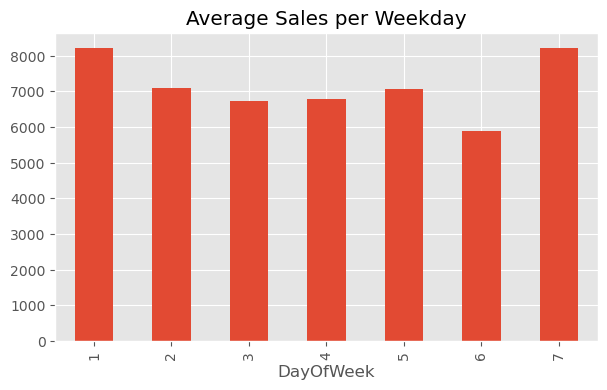

In [28]:
sale_day.plot(kind = 'bar',x= 'DayOfWeek', y = 'Average_sales_per_weekday', figsize =(7,4),legend=False,title = 'Average Sales per Weekday')
plt.show()

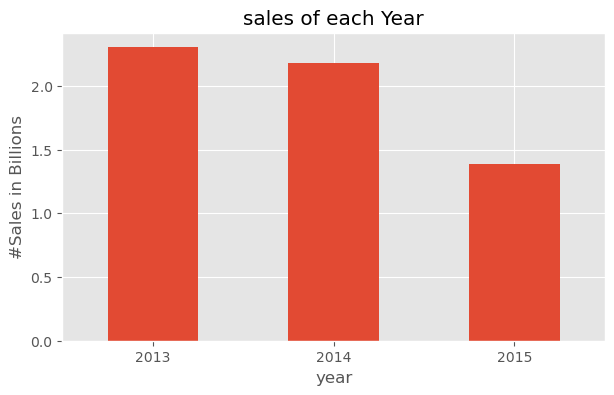

In [29]:
#Yearly Sales trend
sales_df_filt['year'] = pd.to_datetime(sales_df_filt['Date']).dt.year
sales_perYear = sales_df_filt.groupby(['year'])['Sales'].sum().reset_index(name='sales_perYear')
sales_perYear.plot(kind = 'bar',x= 'year', y = 'sales_perYear', figsize =(7,4),legend=False,title = 'sales of each Year',rot = 0)
plt.ylabel('#Sales in Billions')
def y_fmt(tick_val, pos):
    val = int(tick_val)/1000000000
    return '{0:.1f}'.format(val)
ax = pl.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))

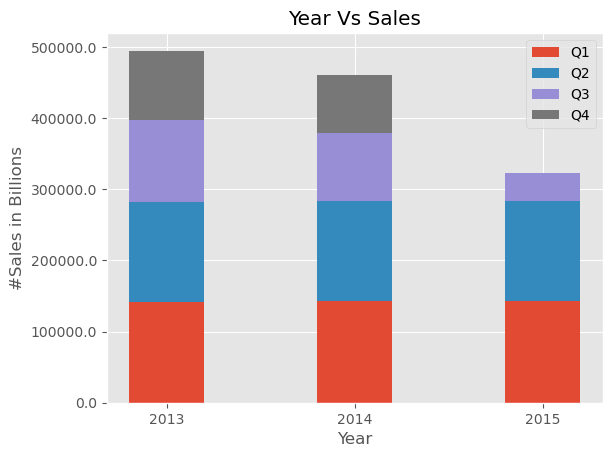

In [30]:
#Yearly sales with quarterly stacked
sales_df_filt['Quarter'] = pd.to_datetime(sales_df_filt['Date']).dt.quarter
sales_df_filt['year'] = pd.to_datetime(sales_df_filt['Date']).dt.year
sales_perQuarter = sales_df_filt.groupby(['Quarter'])['Sales'].sum().reset_index(name='sales_per_Quarter')
df = sales_perQuarter[['Quarter','sales_per_Quarter']].merge(sales_df_filt[['year','Quarter']],how='left')
df=df[df['year'].isin([2013,2014,2015])]
df1 = df.groupby(['Quarter','year']).sum().reset_index()
df1.loc[len(df1.index)] = [4, 2015, 0]
x = ['2013','2014','2015']
q1=list(df1[df1.Quarter==1]['sales_per_Quarter'])
q2=list(df1[df1.Quarter==2]['sales_per_Quarter'])
q3=list(df1[df1.Quarter==3]['sales_per_Quarter'])
q4=list(df1[df1.Quarter==4]['sales_per_Quarter'])
q3_cummu=list(np.add(q1,q2))
q4_cummu=list(np.add(q3_cummu,q3))
plt.bar(x,q1, 0.4,label='Q1')
plt.bar(x,q2,0.4,bottom=q1,label='Q2')
plt.bar(x,q3,0.4, bottom=q3_cummu,label='Q3')
plt.bar(x,q4,0.4, bottom=q4_cummu,label='Q4')
plt.xlabel('Year')
#plt.ylabel('Sales')
plt.title('Year Vs Sales')
plt.legend(loc='upper right')
plt.ylabel('#Sales in Billions')
def y_fmt(tick_val, pos):
    val = int(tick_val)/1000000000
    return '{0:.1f}'.format(val)
ax = pl.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
plt.show()

In [31]:
sales_df_filt['month'] = pd.to_datetime(sales_df_filt['Date']).dt.month
sales_df_filt['month'][sales_df_filt['year'] == 2015].unique()

array([7, 6, 5, 4, 3, 2, 1], dtype=int64)

From the above bar graph we can see the sales are less when compared to 2013 and 2014. It is because that we only have data for 2015 upto the July month. Otherwise no of sales are quite similar for all the years.

In [32]:
#Merging Sales data and store data
store_sales_df_filt = sales_df_filt.merge(store_df, on='Store',how='left')

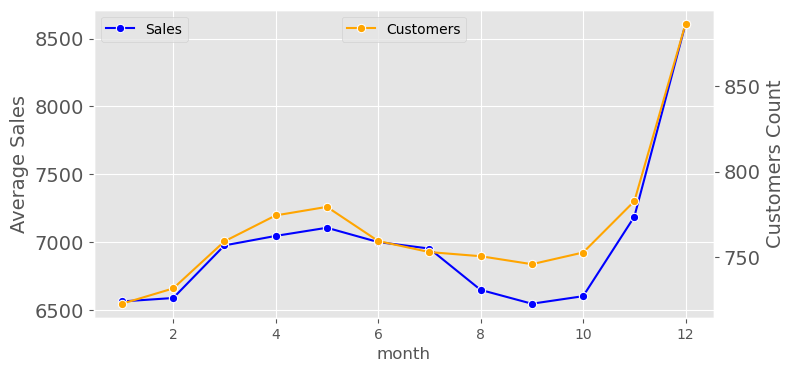

In [33]:
#Average sales and number of customers per month

plt.figure(figsize=(8,4))
store_sales_df_filt['month'] = pd.DatetimeIndex(store_sales_df_filt['Date']).month
axis1 = store_sales_df_filt.groupby(['month']).agg({'Sales':'mean','Customers':'mean'})
ax1 = sns.lineplot(
    x=axis1.index, 
    y='Sales', 
    data=axis1,  
    color='blue',
    marker='o'
)
ax1.set_ylabel('Average Sales')
ax1.legend(['Sales'], loc="upper left")
ax1.yaxis.label.set_fontsize(14)
ax1.tick_params(axis='y', labelsize=14)
# set up the 2nd axis
ax2 = ax1.twinx()
# plot bar chart on axis #2
sns.lineplot(
    x=axis1.index, 
    y='Customers', 
    data=axis1, 
    ax = ax2,
    color = 'Orange',
    marker='o'# Pre-existing axes for the plot
)
ax2.grid(False) # turn off grid #2
ax2.set_ylabel('Customers Count')
ax2.legend(['Customers'], loc="upper center")
ax2.yaxis.label.set_fontsize(14)
ax2.tick_params(axis='y',  labelsize=14)

It is obvious that stores will have more customers and generate more sales in December (during the Christmas season). Also, there’s another much smaller peak in April/May.

#### Visualisations based on Store ID

<AxesSubplot:xlabel='Date'>

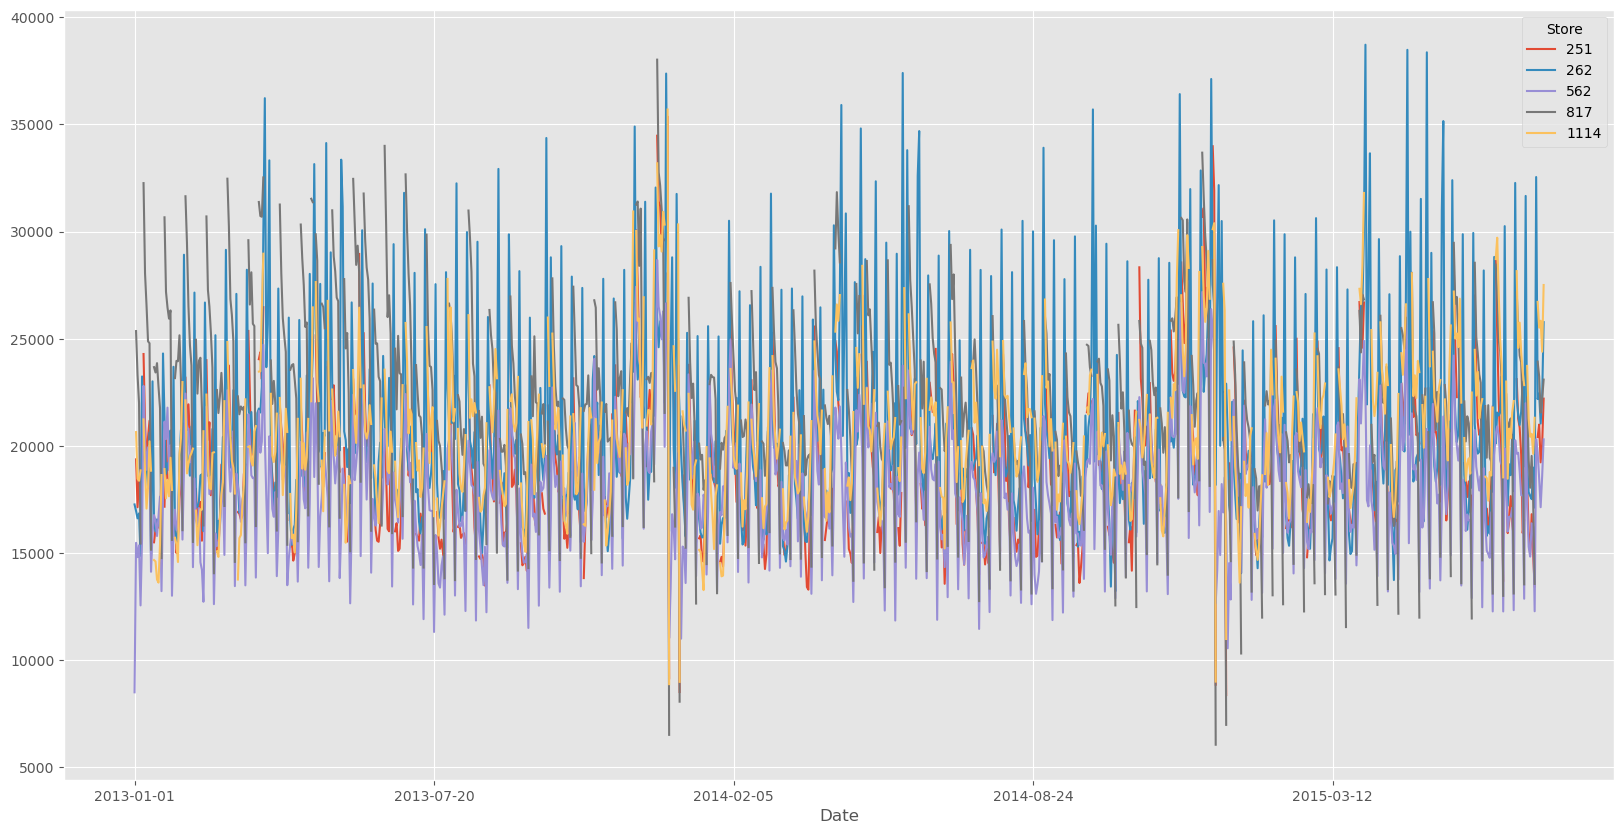

In [34]:
#Store Vs Sales plot - Top 5 stores
top5_store = store_sales_df_filt.groupby('Store').sum().sort_values(by='Sales', ascending=False).reset_index()[0:5]['Store'].to_list()
fig, ax = plt.subplots(figsize = (20,10))
store_sales_plot_df=store_sales_df_filt[store_sales_df_filt['Store'].isin(top5_store)]
store_sales_plot_df.groupby(['Date', 'Store']).mean()['Sales'].unstack().plot(ax = ax)

We can observe that no of sales is higher in store - 114 and sales amount is higher in store - 251

#### Visualisations based on Store Promotions

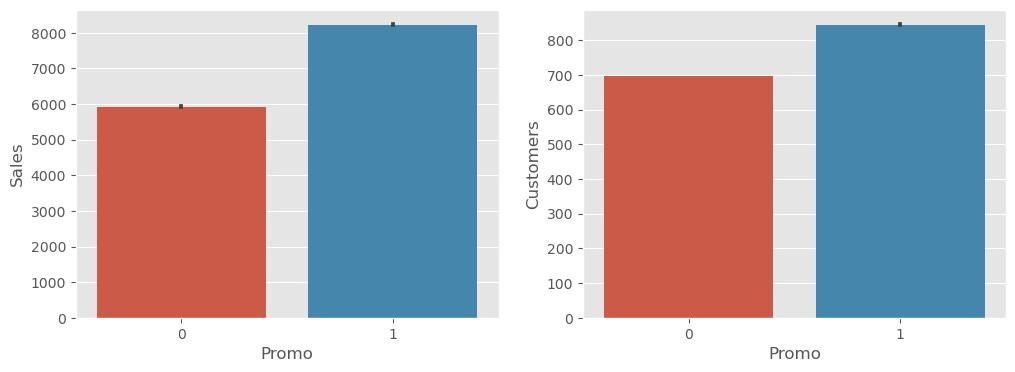

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.barplot(x="Promo", y="Sales", data=store_sales_df_filt)
plt.subplot(122)
sns.barplot(x="Promo", y="Customers", data=store_sales_df_filt)
plt.show()

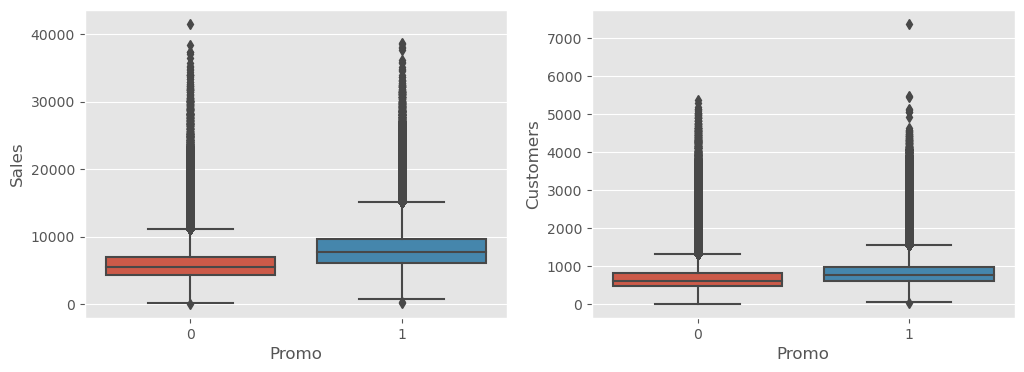

In [36]:
#Boxplot
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.boxplot(x="Promo", y="Sales", data=store_sales_df_filt)
plt.subplot(122)
sns.boxplot(x="Promo", y="Customers", data=store_sales_df_filt)
plt.show()

It is obvious that sales and customers are high when the store is running a product promotion. The median sales under product promotion were significantly higher than those under no promotion. The lower quartiles for sales under promotion exceeded the median sales under no promotion. Therefore, the sales promotion variable appears to be a possible predictor of the
sales volumes.

#### Visualisations based on State Holiday

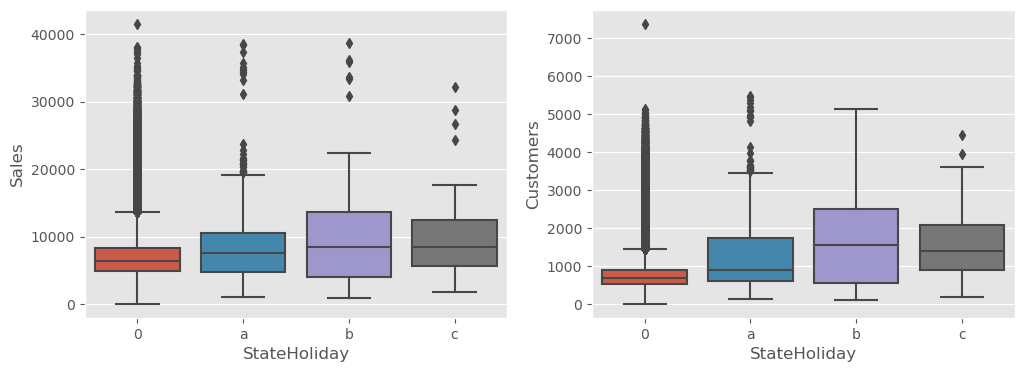

In [37]:
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
store_sales_df_filt['StateHoliday'] = store_sales_df_filt['StateHoliday'].astype(str)
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.boxplot(x="StateHoliday", y="Sales", data=store_sales_df_filt)
plt.subplot(122)
sns.boxplot(x="StateHoliday", y="Customers", data=store_sales_df_filt)
plt.show()

People are more likely to buy more over the Christmas and Easter holidays. Therefore, sales and customer visits are higher. 
However, there is minor variation in public choice during these festivals.

#### Visualisations based on School Holiday

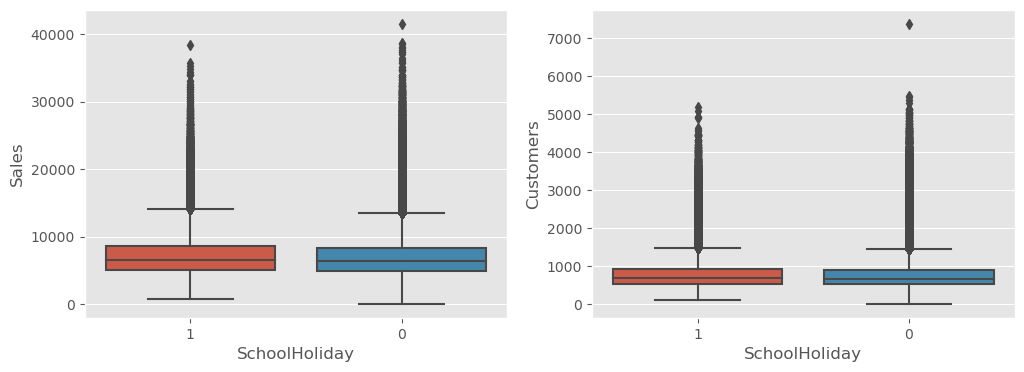

In [38]:
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
store_sales_df_filt['SchoolHoliday'] = store_sales_df_filt['SchoolHoliday'].astype(str)
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.boxplot(x="SchoolHoliday", y="Sales", data=store_sales_df_filt)
plt.subplot(122)
sns.boxplot(x="SchoolHoliday", y="Customers", data=store_sales_df_filt)
plt.show()

There is no much effect of closure or open of School on Sales or Customers.

#### Visualisations based on Competitor distance

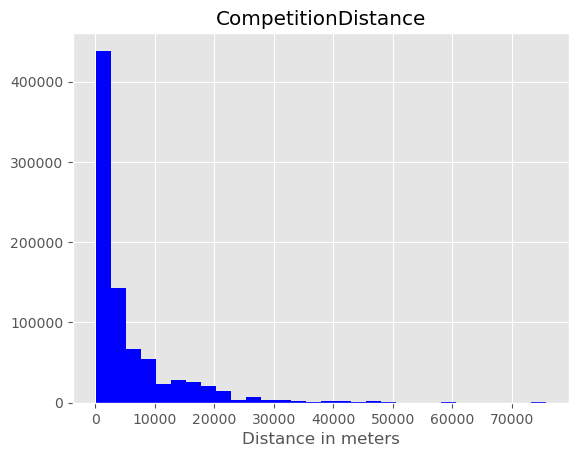

In [39]:
#Distribution of Competition distance
store_sales_df_filt.hist(column='CompetitionDistance', bins=30,color='b')
plt.xlabel('Distance in meters')
plt.show()

It appears that there are fewer competitors near Rossman’s store. Despite several competitors being located near Rossman’s store, the sale is considerably superior to the competition.

#### Visualisations based on Store Type

In [40]:
store_sales_df_filt['sales_perCustomer'] = store_sales_df_filt['Sales']/store_sales_df_filt['Customers']
avg_salesPerCustomer = store_sales_df_filt.groupby('Store').agg({'sales_perCustomer':'mean','StoreType':'first','Assortment':'first','Promo2':'first','PromoInterval':'first'}).reset_index()
avg_salesPerCustomer

,Store,sales_perCustomer,StoreType,Assortment,Promo2,PromoInterval
0,1,8.393038,c,a,0,0
1,2,8.408443,a,a,1,"Jan,Apr,Jul,Oct"
2,3,9.117599,a,a,1,"Jan,Apr,Jul,Oct"
3,4,7.249827,c,c,0,0
4,5,8.611229,a,a,0,0
...,...,...,...,...,...,...
1110,1111,11.547388,a,a,1,"Jan,Apr,Jul,Oct"
1111,1112,11.993853,c,c,0,0
1112,1113,9.211189,a,c,0,0
1113,1114,6.454992,a,c,0,0


#### Visualisations based on Store Type Assortment Type

<AxesSubplot:xlabel='Date'>

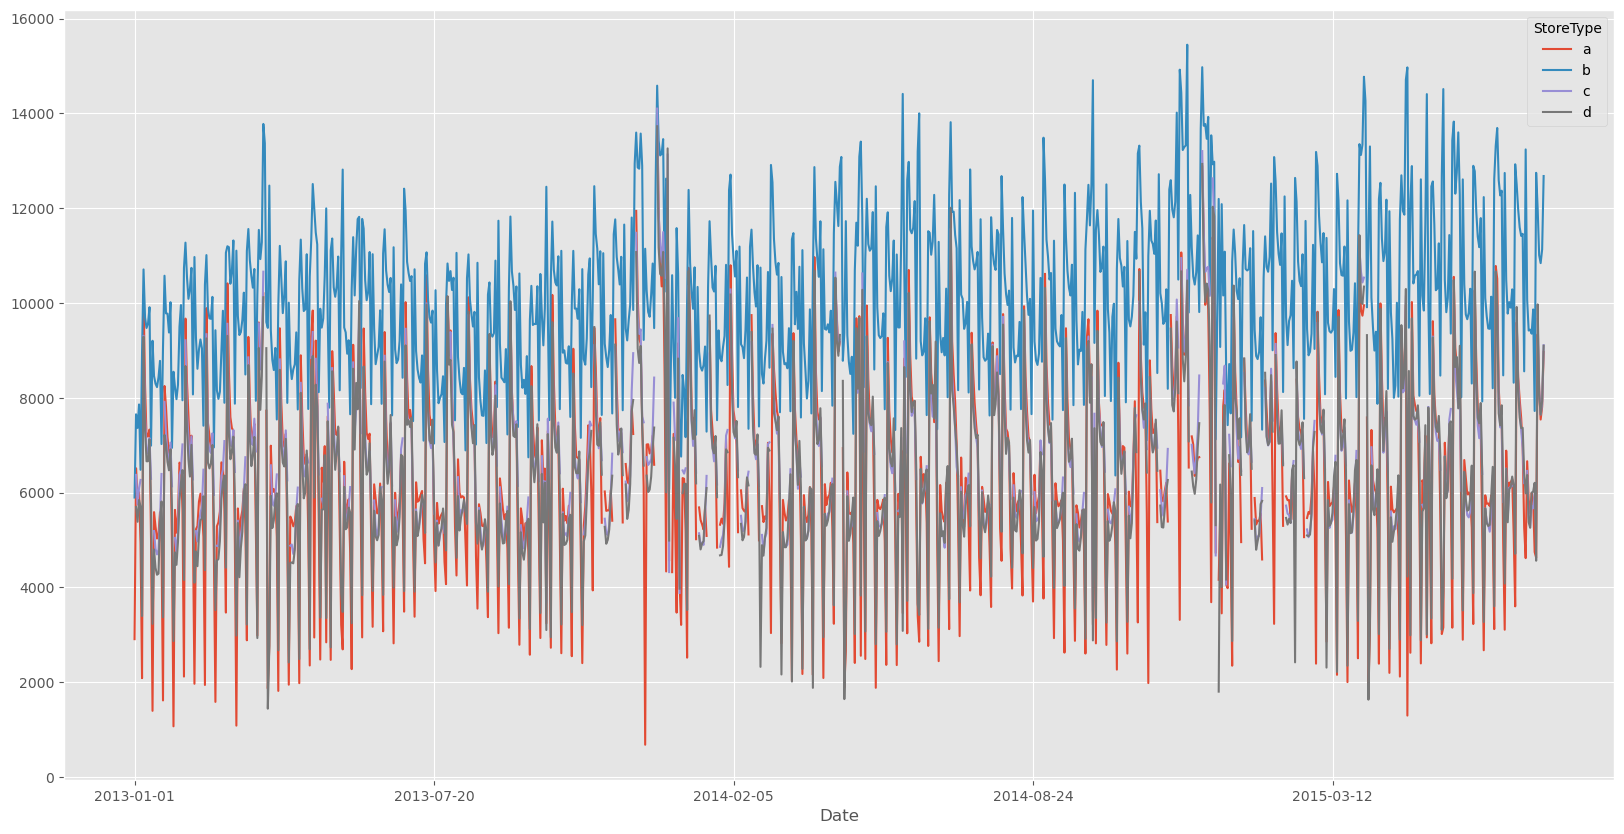

In [41]:
fig, ax = plt.subplots(figsize = (20,10))
store_sales_df_filt.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax)

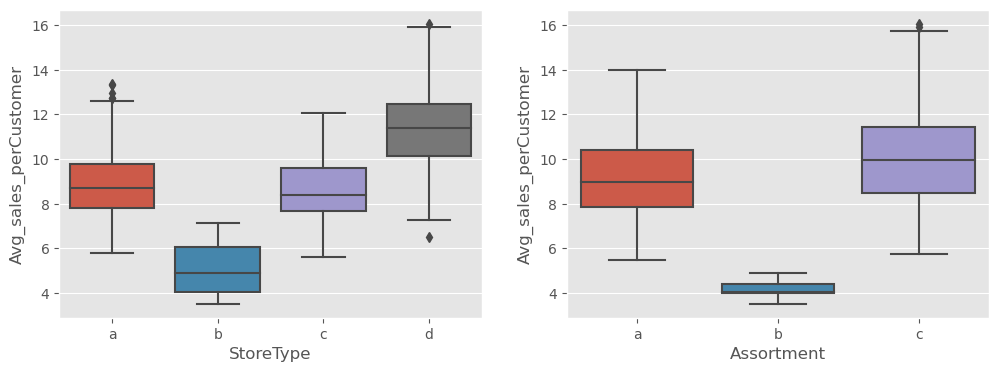

In [42]:
plt.figure(figsize=(12,4))
plt.subplot(121)
ax = sns.boxplot(x="StoreType", y="sales_perCustomer", data=avg_salesPerCustomer.sort_values(['StoreType']))
ax.set(ylabel = 'Avg_sales_perCustomer')

plt.subplot(122)
ax = sns.boxplot(x="Assortment", y="sales_perCustomer", data=avg_salesPerCustomer.sort_values(['Assortment']))
ax.set(ylabel = 'Avg_sales_perCustomer')
plt.show()

Store type d has more significant sales rate than the a and c types, while the b type has a relatively low sales rate.
Assortment B recorded the lowest sales, while C has bit higher sales when compared to A.

#### Visualisations based on Promo2 and Promo Interval

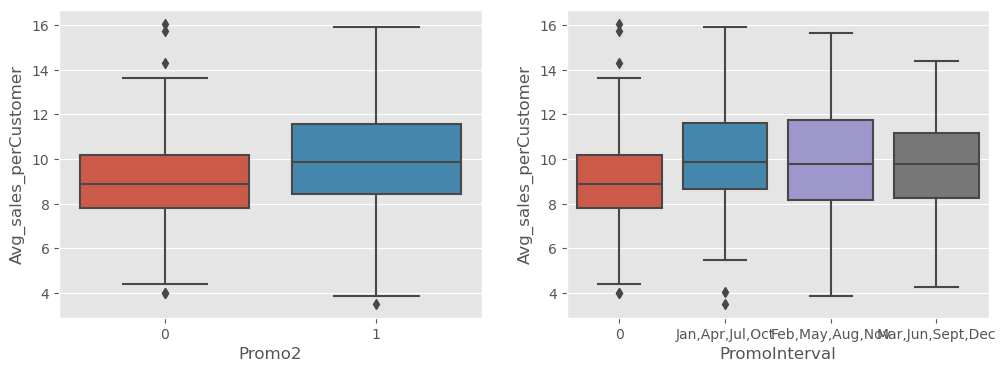

In [43]:
plt.figure(figsize=(12,4))
plt.subplot(121)
ax = sns.boxplot(x="Promo2", y="sales_perCustomer", data=avg_salesPerCustomer.sort_values(['Promo2']))
ax.set(ylabel = 'Avg_sales_perCustomer')
plt.subplot(122)
ax = sns.boxplot(x="PromoInterval", y="sales_perCustomer", data=avg_salesPerCustomer)
ax.set(ylabel = 'Avg_sales_perCustomer')
plt.show()

Sales rate for stores continuing the promotion is high, although the difference is negligible. 

#### Distribution of Sales column

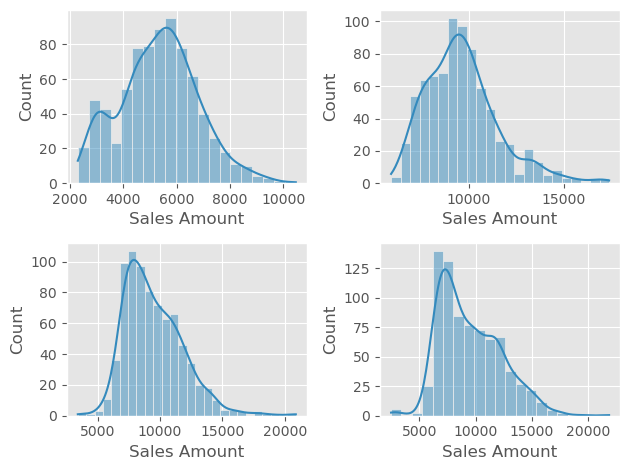

In [46]:
#Checking distribution of sales of some random stores using histogram
fig, axes = plt.subplots(2, 2)
axes = axes.ravel() 
stores = store_sales_df_filt['Store'].sample(n = 4,random_state=42).to_list()
for store, ax in zip(stores, axes):
    a = sns.histplot(data=store_sales_df_filt['Sales'][store_sales_df_filt['Store']==store], kde=True, stat='count', ax=ax)
    a.set_xlabel("Sales Amount")
fig.tight_layout()
plt.show()

The above plot shows that the sales are not normally distributed. They are either Rightly skewed or left skewed.
To convert sales into normal distribution we can apply log transformation on Sales column

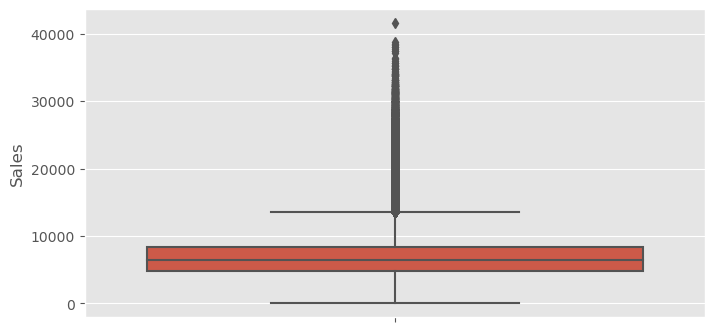

In [45]:
#Box plot of sales of all stores
plt.figure(figsize=(8,4))
ax = sns.boxplot(y="Sales", data=store_sales_df_filt)
plt.show()

In [46]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

In [47]:
store_sales_df = sales_df.merge(store_df, on='Store',how='left')
for i in store_sales_df['Store'].unique():
    store_sales_df.loc[(store_sales_df['Store'] == i) & (store_sales_df['Open'] == 1), 'Outlier'] = \
        mad_based_outlier(store_sales_df.loc[(store_sales_df['Store'] == i) & (store_sales_df['Open'] == 1)]['Sales'], 3.5)

In [48]:
outliers = store_sales_df[store_sales_df['Outlier'] == True]
outliers.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Outlier
273,274,5,2015-07-31,6975,1374,1,1,0,1,b,b,3640.0,9.0,2013.0,1,10.0,2013.0,"Jan,Apr,Jul,Oct",True
376,377,5,2015-07-31,14940,1400,1,1,0,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov",True
503,504,5,2015-07-31,10679,1117,1,1,0,1,c,c,820.0,9.0,2013.0,0,0.0,0.0,0,True
550,551,5,2015-07-31,11632,1278,1,1,0,1,a,c,2190.0,9.0,2013.0,0,0.0,0.0,0,True
599,600,5,2015-07-31,12377,898,1,1,0,1,d,c,17340.0,6.0,2010.0,1,9.0,2011.0,"Feb,May,Aug,Nov",True


In [49]:
print('Length of the dataset:', len(store_sales_df))
print('Length of Outliers:', len(outliers))
print('Percentage of outliers: %.2f%% ' %((len(outliers)/len(store_sales_df))*100))


Length of the dataset: 1017209
Length of Outliers: 6425
Percentage of outliers: 0.63% 


As the percentage of outliers is just 0.63% we can drop those records

In [50]:
#Filter non outliers data
store_sales_df = store_sales_df[store_sales_df['Outlier'].isin([False,np.nan])]
store_sales_df.shape
store_sales_df = store_sales_df.drop(columns='Outlier')

In [51]:
store_sales_df['Sales_norm'] = np.log(store_sales_df['Sales'])
store_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales_norm
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,8.568456
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",8.710125
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",9.025696
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,9.546455
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,8.480944


## Feature Engineering

In [52]:
#Creating date features
store_sales_df['Date'] = pd.to_datetime(store_sales_df['Date'])
store_sales_df['year'] = store_sales_df['Date'].dt.year
store_sales_df['month'] = store_sales_df['Date'].dt.month
store_sales_df['day'] = store_sales_df['Date'].dt.day
store_sales_df['weekOfYear'] = store_sales_df['Date'].dt.weekofyear
store_sales_df['dayOfYear'] = store_sales_df['Date'].dt.dayofyear
store_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales_norm,year,month,day,weekOfYear,dayOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0.0,0.0,0,8.568456,2015,7,31,31,212
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13.0,2010.0,"Jan,Apr,Jul,Oct",8.710125,2015,7,31,31,212
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14.0,2011.0,"Jan,Apr,Jul,Oct",9.025696,2015,7,31,31,212
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,0.0,0.0,0,9.546455,2015,7,31,31,212
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,0.0,0.0,0,8.480944,2015,7,31,31,212


In [53]:
#Creating Sales features
store_sales_df['sales_perCustomer'] = store_sales_df['Sales']/store_sales_df['Customers']
store_sales_df['avg_sales_per_store'] = store_sales_df.groupby(['Store'])['Sales'].transform('mean')
store_sales_df['avg_customers_per_store'] = store_sales_df.groupby(['Store'])['Customers'].transform('mean')
store_sales_df['sales_percustomers_perstore'] = store_sales_df['avg_sales_per_store']/store_sales_df['avg_customers_per_store']
store_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Sales_norm,year,month,day,weekOfYear,dayOfYear,sales_perCustomer,avg_sales_per_store,avg_customers_per_store,sales_percustomers_perstore
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,8.568456,2015,7,31,31,212,9.482883,3919.890075,464.921025,8.431303
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,8.710125,2015,7,31,31,212,9.702400,4095.846482,484.134328,8.460145
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,9.025696,2015,7,31,31,212,10.126675,5730.682253,619.678002,9.247839
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.546455,2015,7,31,31,212,9.342457,7930.276824,1090.427039,7.272634
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,8.480944,2015,7,31,31,212,8.626118,3843.854100,442.632588,8.684074


In [54]:
#Splitting PromoInterval into different columns. (Jan,March,May) --> Jan, March, May.
s = store_sales_df['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
store_sales_df = store_sales_df.join(s)

#Converting Promointerval columns to numerical.
month_to_num_dict = {'Jan' : 1,'Feb' : 2,'Mar' : 3,'Apr' : 4,'May' : 5,'Jun' : 6,'Jul' : 7,'Aug' : 8,'Sept' : 9,'Oct' : 10,'Nov' : 11, 'Dec' : 12}

store_sales_df['PromoInterval0'] = store_sales_df['PromoInterval0'].map(month_to_num_dict)
store_sales_df['PromoInterval1'] = store_sales_df['PromoInterval1'].map(month_to_num_dict)
store_sales_df['PromoInterval2'] = store_sales_df['PromoInterval2'].map(month_to_num_dict)
store_sales_df['PromoInterval3'] = store_sales_df['PromoInterval3'].map(month_to_num_dict)

#Removing PromoInterval feature.
del store_sales_df['PromoInterval']
store_sales_df['PromoInterval0'].fillna('0',inplace=True)
store_sales_df['PromoInterval1'].fillna('0',inplace=True)
store_sales_df['PromoInterval2'].fillna('0',inplace=True)
store_sales_df['PromoInterval3'].fillna('0',inplace=True)

In [55]:
#Finding no of holidays in each week in a year for respective store.
store_sales_df['StateHolidays_perweek'] = store_sales_df.groupby(['Store','weekOfYear','year'])['StateHoliday'].transform(lambda x:len(x[x !='0']))
store_sales_df['SchoolHolidays_perweek'] = store_sales_df.groupby(['Store','weekOfYear','year'])['SchoolHoliday'].transform(lambda x:len(x[x !='0']))
store_sales_df['sales_perCustomer'].fillna('0',inplace=True)

In [56]:
#checking correlation of all the features
correlation = store_sales_df.corr()
correlation

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,year,month,day,weekOfYear,dayOfYear,avg_sales_per_store,avg_customers_per_store,sales_percustomers_perstore,StateHolidays_perweek,SchoolHolidays_perweek
Store,1.000000,0.000205,0.005777,0.025129,0.000017,-0.000137,0.000767,-0.026298,-0.037176,-0.000190,...,0.000346,0.001428,0.000042,0.001356,0.001427,0.010731,0.036252,-0.054759,0.000875,0.002908
DayOfWeek,0.000205,1.000000,-0.459970,-0.385537,-0.529304,-0.391027,-0.204724,0.000456,-0.000032,-0.000186,...,0.000321,0.001601,0.006910,0.002463,0.002179,-0.000225,-0.000950,0.001069,0.000128,-0.039015
Sales,0.005777,-0.459970,1.000000,0.895703,0.686165,0.453407,0.083657,-0.020435,-0.023082,0.008389,...,0.027380,0.035793,-0.015080,0.039416,0.034271,0.538329,0.452304,-0.019932,-0.016294,-0.027715
Customers,0.025129,-0.385537,0.895703,1.000000,0.620419,0.316299,0.070264,-0.103701,-0.023803,0.006091,...,0.001155,0.029181,-0.006382,0.032142,0.028500,0.582393,0.693161,-0.335142,-0.005501,-0.007562
Open,0.000017,-0.529304,0.686165,0.620419,1.000000,0.294462,0.085808,0.007859,0.001413,0.002468,...,-0.000405,-0.003541,0.032884,0.001845,-0.000488,0.017800,0.032057,-0.017267,-0.002333,0.036186
Promo,-0.000137,-0.391027,0.453407,0.316299,0.294462,1.000000,0.070390,0.000111,-0.000029,0.000185,...,0.024985,-0.015156,-0.109025,-0.002942,-0.024761,0.000384,0.000832,-0.000876,-0.024892,-0.064663
SchoolHoliday,0.000767,-0.204724,0.083657,0.070264,0.085808,0.070390,1.000000,-0.004636,0.000141,0.001681,...,-0.037090,0.102761,0.028427,0.070049,0.104215,0.003950,0.004905,-0.003805,0.110451,-0.029578
CompetitionDistance,-0.026298,0.000456,-0.020435,-0.103701,0.007859,0.000111,-0.004636,1.000000,-0.048501,0.020881,...,0.000984,0.002506,-0.000078,0.002315,0.002491,-0.037961,-0.149605,0.233594,0.002158,-0.002657
CompetitionOpenSinceMonth,-0.037176,-0.000032,-0.023082,-0.023803,0.001413,-0.000029,0.000141,-0.048501,1.000000,0.058270,...,-0.000286,-0.000217,0.000107,-0.000212,-0.000207,-0.042877,-0.034340,0.008894,0.000488,-0.001172
CompetitionOpenSinceYear,-0.000190,-0.000186,0.008389,0.006091,0.002468,0.000185,0.001681,0.020881,0.058270,1.000000,...,0.000854,0.003141,0.000043,0.003043,0.003135,0.015584,0.008787,0.005393,0.001047,-0.001795


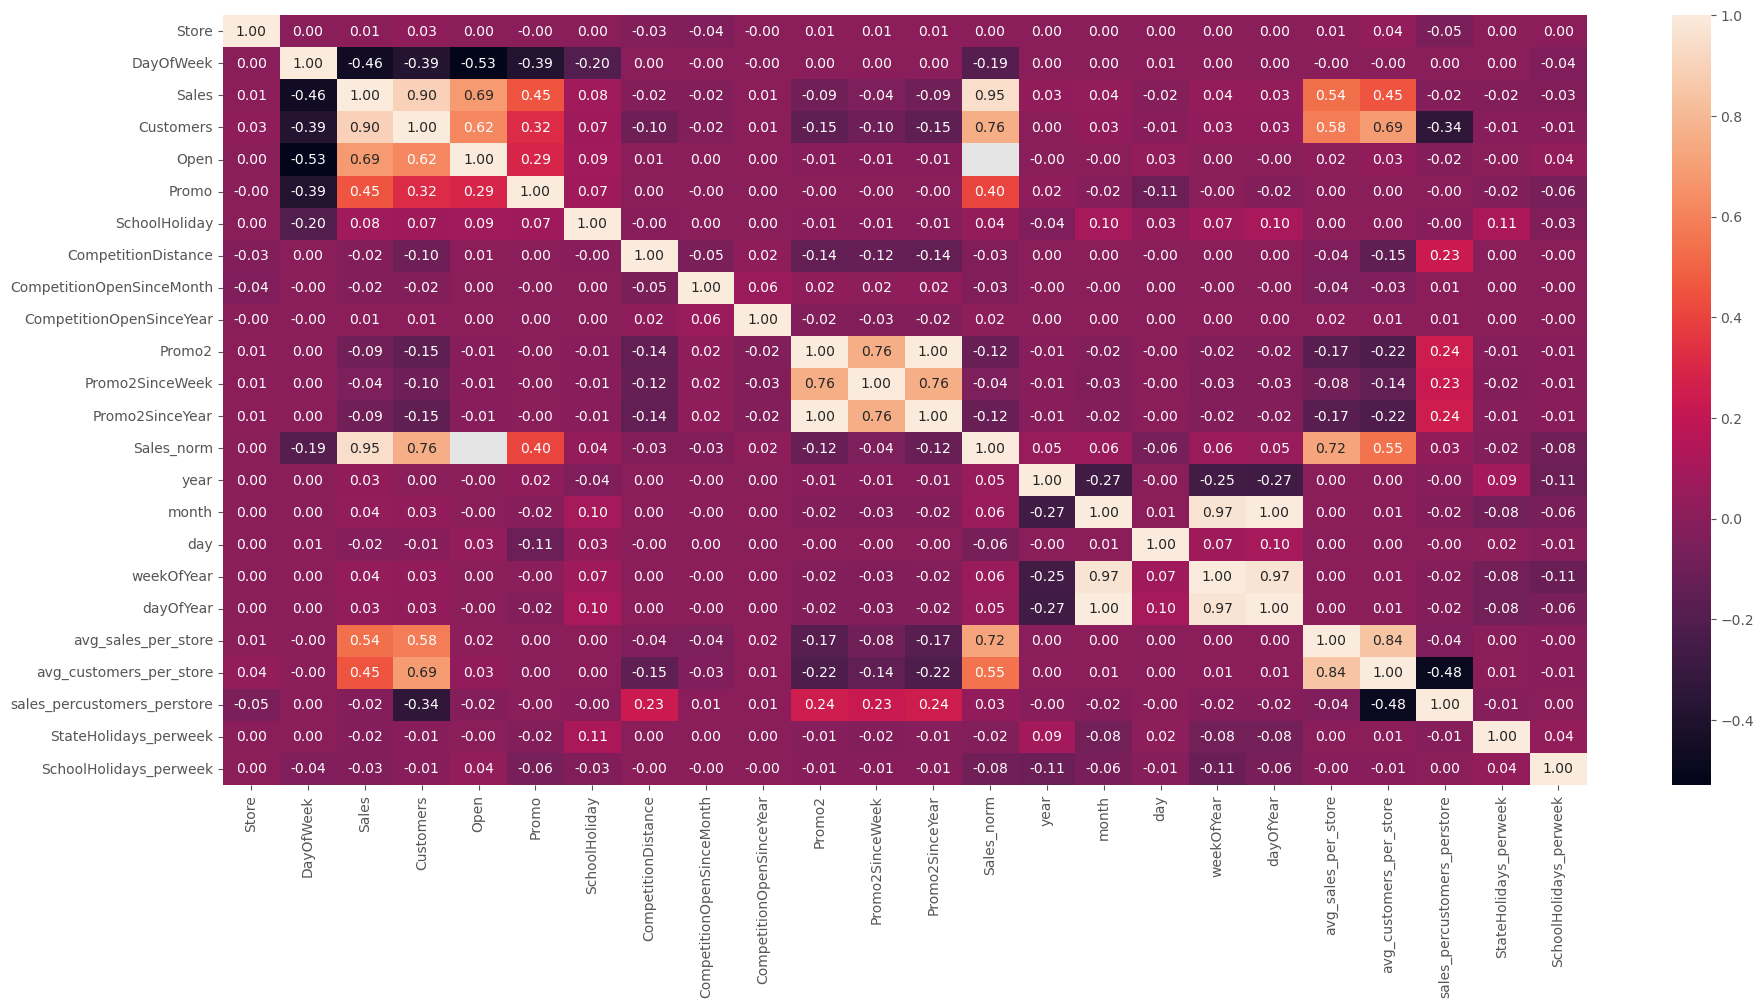

In [57]:
# Heat Map
plt.figure(figsize=(22,10))
sns.heatmap(correlation, annot=True,fmt='.2f')
plt.show()

In [58]:
def get_corr_pairs(df):
    au_corr = df.corr().abs().unstack().sort_values()
    au_corr = pd.DataFrame(au_corr)
    au_corr.reset_index(inplace=True)
    au_corr.columns = ['col1','col2','corr_value']
    au_corr['col2'] = np.where(au_corr['corr_value'] < 0.3,'',au_corr['col2'])
    au_corr = au_corr.groupby('col1')['col2'].apply(list).reset_index(name='cols_list') 
    au_corr['cols_list'] = au_corr['cols_list'].apply(lambda x:list(filter(None,x)))
    corr_dict = dict(zip(au_corr.col1, au_corr.cols_list))
    return corr_dict

In [59]:
get_corr_pairs(store_sales_df)

{'CompetitionDistance': ['CompetitionDistance'],
 'CompetitionOpenSinceMonth': ['CompetitionOpenSinceMonth'],
 'CompetitionOpenSinceYear': ['CompetitionOpenSinceYear'],
 'Customers': ['Promo',
  'sales_percustomers_perstore',
  'DayOfWeek',
  'avg_sales_per_store',
  'Open',
  'avg_customers_per_store',
  'Sales_norm',
  'Sales',
  'Customers'],
 'DayOfWeek': ['Customers', 'Promo', 'Sales', 'Open', 'DayOfWeek'],
 'Open': ['DayOfWeek', 'Customers', 'Sales', 'Open', 'Sales_norm'],
 'Promo': ['Customers', 'DayOfWeek', 'Sales_norm', 'Sales', 'Promo'],
 'Promo2': ['Promo2SinceWeek', 'Promo2SinceYear', 'Promo2'],
 'Promo2SinceWeek': ['Promo2SinceYear', 'Promo2', 'Promo2SinceWeek'],
 'Promo2SinceYear': ['Promo2SinceWeek', 'Promo2', 'Promo2SinceYear'],
 'Sales': ['avg_customers_per_store',
  'Promo',
  'DayOfWeek',
  'avg_sales_per_store',
  'Open',
  'Customers',
  'Sales_norm',
  'Sales'],
 'Sales_norm': ['Promo',
  'avg_customers_per_store',
  'avg_sales_per_store',
  'Customers',
  'Sales'

Target Column 'Sales' is highly correlated with below features.
- avg_customers_per_store
- Promo
- DayOfWeek
- avg_sales_per_store
- Open
- Customers
- Sales

## Data Preprocessing

In [60]:
#Converting cyclic natured features into numerical columns using trignometric based feature transformation
cyclic_features = ['DayOfWeek','year','month','weekOfYear','dayOfYear']
for col in cyclic_features:
    max_value = store_sales_df[col].max()
    store_sales_df[col+'_sin'] = np.sin(store_sales_df[col] * (2 * np.pi / max_value))
    store_sales_df[col+'_cos'] = np.cos(store_sales_df[col] * (2 * np.pi / max_value))

In [61]:
#Converting Categorical features into Numeric columns using One hot encoding
store_sales_df['StateHoliday'].replace(0,'0',inplace=True)
categorical_features = ['StoreType','Assortment','StateHoliday','SchoolHoliday']
store_sales_df = pd.get_dummies(store_sales_df,columns=categorical_features)
store_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,StoreType_d,Assortment_a,Assortment_b,Assortment_c,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,SchoolHoliday_0,SchoolHoliday_1
0,1,5,2015-07-31,5263,555,1,1,1270.0,9.0,2008.0,...,0,1,0,0,1,0,0,0,0,1
1,2,5,2015-07-31,6064,625,1,1,570.0,11.0,2007.0,...,0,1,0,0,1,0,0,0,0,1
2,3,5,2015-07-31,8314,821,1,1,14130.0,12.0,2006.0,...,0,1,0,0,1,0,0,0,0,1
3,4,5,2015-07-31,13995,1498,1,1,620.0,9.0,2009.0,...,0,0,0,1,1,0,0,0,0,1
4,5,5,2015-07-31,4822,559,1,1,29910.0,4.0,2015.0,...,0,1,0,0,1,0,0,0,0,1


## Modelling

#### Linear Regression

In [111]:
#store_sales_df.set_index('Date', inplace=True)
store_sales_df.sort_index(inplace=True,ascending=False)

X = store_sales_df.drop(['Sales','Customers','Sales_norm'],axis=1)
Y = store_sales_df['Sales_norm']
Y = Y.replace([np.inf, -np.inf], 0)
#X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=23)
tss = TimeSeriesSplit(n_splits = 5,test_size=None)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(842320, 49) (168464, 49) (842320,) (168464,)


In [112]:
#Scaling numeric variables
numeric_features = ['CompetitionDistance','sales_perCustomer','avg_sales_per_store','avg_customers_per_store','sales_percustomers_perstore']
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [113]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
X_train.drop(['Date'],axis=1,inplace=True)
X_test.drop(['Date'],axis=1,inplace=True)

In [65]:
#Training Linear Regression model
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [66]:
#display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, model.score(X_train, y_train))

-1466.9731818254984 [-3.89298905e-06 -6.21869366e-02  7.80231677e+00  2.31467620e-01
 -6.26430972e-03  6.27862727e-05  3.27987427e-04 -8.46344289e-03
  5.81084830e-04  2.08284758e-04  8.13838990e-03  3.10080971e-03
 -9.33169638e-04  1.07470745e-03  2.51066760e-04  2.80346476e-01
  3.24737489e-01 -7.79997371e-02 -1.29748375e-01  3.63546539e-02
  1.09765881e-02 -1.44119592e-02 -3.99247052e-02 -3.29835653e-04
 -2.21194386e-02 -1.03853344e-01  3.34758429e-02 -4.52386010e+00
  1.45079257e+03  8.12049195e-02  1.53541067e-02 -9.95404766e-02
  1.56956314e-01  9.85231456e-02 -1.68255630e-01  9.89951766e-03
 -6.91057521e-02  3.19825518e-02  2.71958076e-02 -7.10569717e-02
  1.43423773e-01 -7.23410454e-02  2.22548798e-01 -1.91953043e-02
 -1.52430171e-01 -5.09200520e-02 -1.29274057e-02  1.29292377e-02] 0.9953842167360931


In [67]:
#Predicting on test data
y_pred = model.predict(X_test)

In [68]:
#Applying inverse log transform
y_pred = np.expm1(y_pred)
y_test_inv_log = np.expm1(y_test)

In [69]:
print('r2_score:',r2_score(y_test_inv_log,y_pred))
print('Mean absolute error: %.2f' % mean_absolute_error(y_test_inv_log,y_pred))
print('Root mean squared error: ', math.sqrt(mean_squared_error(y_test_inv_log,y_pred)))
print('Root mean squared percentage error: ', rmspe(y_test_inv_log, y_pred))

r2_score: 0.8849357387797314
Mean absolute error: 813.58
Root mean squared error:  1315.7640685848817
Root mean squared percentage error:  2.306250463994982


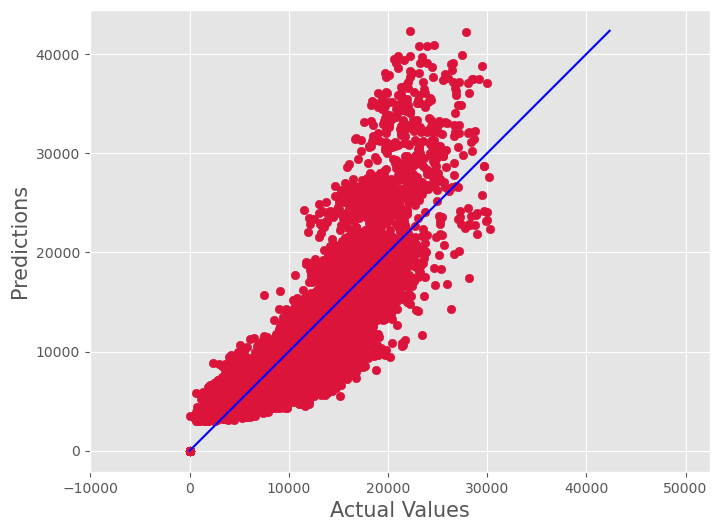

In [70]:
plt.figure(figsize=(8,6))
plt.scatter(y_test_inv_log, y_pred, c='crimson')
p1 = max(max(y_pred), max(y_test_inv_log))
p2 = min(min(y_pred), min(y_test_inv_log))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

#### DecisionTree Regressor

In [71]:
#Training Decision tree and predicting on test data
model_dt=DecisionTreeRegressor(max_depth=10,random_state=1)
model_dt.fit(X_train,y_train)
y_pred_dt = model_dt.predict(X_test)

In [72]:
y_pred_dt = np.expm1(y_pred_dt)
#print('r2_score:',r2_score(y_test_inv_log,y_pred_dt))
print('Mean absolute error: %.2f' % mean_absolute_error(y_test_inv_log,y_pred_dt))
print('Root mean squared error: ', math.sqrt(mean_squared_error(y_test_inv_log,y_pred_dt)))
print('Root mean squared percentage error: ', rmspe(y_test_inv_log, y_pred_dt))

Mean absolute error: 770.94
Root mean squared error:  1187.9021870584604
Root mean squared percentage error:  1.8524788855523795


In [73]:
#Using gridsearchCV to tune the hyperparameters
parameters = {'max_depth':[2,4,6,8,10,12,15,20,30]}
base_model= DecisionTreeRegressor()
cv_model = GridSearchCV(base_model, param_grid = parameters).fit(X_train, y_train)
cv_model.best_params_

{'max_depth': 20}

In [74]:
#Predicting on testdata
y_pred_dt_cv = cv_model.predict(X_test)
y_pred_dt_cv = np.expm1(y_pred_dt_cv)
#print('r2_score:',r2_score(y_test_inv_log,y_pred_dt_cv))
print('Mean absolute error: %.2f' % mean_absolute_error(y_test_inv_log,y_pred_dt_cv))
print('Root mean squared error: ', math.sqrt(mean_squared_error(y_test_inv_log,y_pred_dt_cv)))
print('Root mean squared percentage error: ', rmspe(y_test_inv_log, y_pred_dt_cv))

Mean absolute error: 651.09
Root mean squared error:  1065.7014947891614
Root mean squared percentage error:  1.5323677191919975


#### RandomForest Regressor

In [75]:
#Random Forest Regressor with n_estimators 200
rf_model = RandomForestRegressor(n_estimators=200,
                          max_features='sqrt',
                          oob_score=True,
                          n_jobs=32,
                          verbose=1,
                          random_state=101)

rf_model.fit(X_train,y_train)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:  4.3min
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:  5.3min finished


RandomForestRegressor(max_features='sqrt', n_estimators=200, n_jobs=32,
                      oob_score=True, random_state=101, verbose=1)

In [76]:
y_pred_rf = rf_model.predict(X_test)
y_pred_rf = np.expm1(y_pred_rf)
#print('r2_score:',r2_score(y_test_inv_log,y_pred_rf))
print('Mean absolute error: %.2f' % mean_absolute_error(y_test_inv_log,y_pred_rf))
print('Root mean squared error: ', math.sqrt(mean_squared_error(y_test_inv_log,y_pred_rf)))
print('Root mean squared percentage error: ', rmspe(y_test_inv_log,y_pred_rf))

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   38.5s
[Parallel(n_jobs=32)]: Done 200 out of 200 | elapsed:   49.3s finished


Mean absolute error: 531.59
Root mean squared error:  877.8310252125322
Root mean squared percentage error:  1.1696680356196614


In [77]:
# Import attributes according to model
pd.options.display.float_format='{:.5f}'.format
important_features=pd.DataFrame(rf_model.feature_importances_,index=X_train.columns)
important_features.sort_values(by=0,ascending=False)
# Visualization of important features
important_features.sort_values(by=0,ascending=False).iplot(mode='markers',title='Important Attributes')

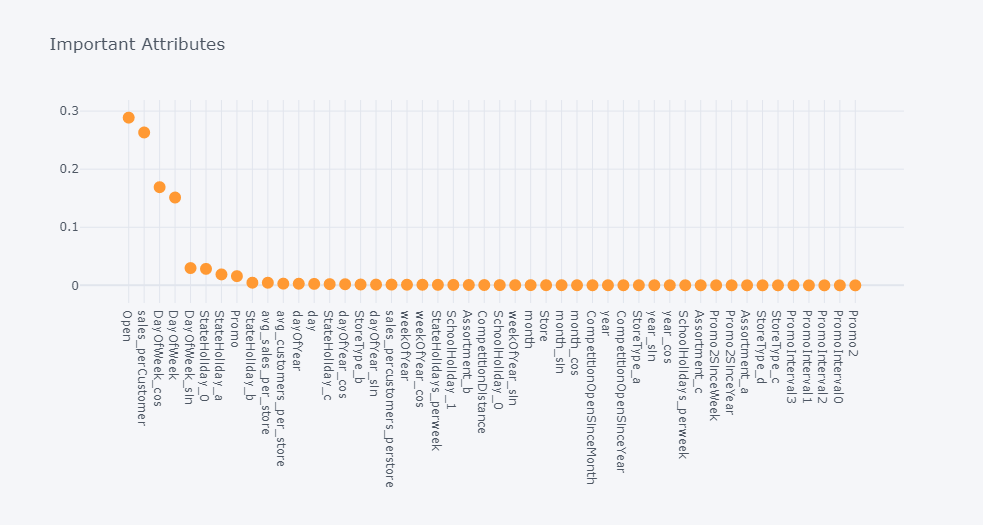

In [159]:
#Reading the above saved image as it will not be displayed when the notebook is opened
from IPython.display import Image
Image(filename='newplot (2).png') 

#### XGBoost Regressor

In [114]:
# Training XGB Regressor
X_train = X_train.drop(['PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3'],axis=1)
X_test = X_test.drop(['PromoInterval0','PromoInterval1','PromoInterval2','PromoInterval3'],axis=1)
xg_cl = xgb.XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)
eval_set1 = [(X_train, y_train), (X_test, y_test)]
xg_cl.fit(X_train, y_train,eval_set=eval_set1, verbose=True)
xg_cl.evals_result()

[0]	validation_0-rmse:6.01691	validation_1-rmse:6.05046
[1]	validation_0-rmse:4.81634	validation_1-rmse:4.85142
[2]	validation_0-rmse:3.85447	validation_1-rmse:3.89184
[3]	validation_0-rmse:3.08524	validation_1-rmse:3.12414
[4]	validation_0-rmse:2.47015	validation_1-rmse:2.50557
[5]	validation_0-rmse:1.98030	validation_1-rmse:2.01671
[6]	validation_0-rmse:1.58893	validation_1-rmse:1.62649
[7]	validation_0-rmse:1.27434	validation_1-rmse:1.31057
[8]	validation_0-rmse:1.02340	validation_1-rmse:1.05964
[9]	validation_0-rmse:0.82296	validation_1-rmse:0.85671
[10]	validation_0-rmse:0.66338	validation_1-rmse:0.69654
[11]	validation_0-rmse:0.53623	validation_1-rmse:0.56707
[12]	validation_0-rmse:0.43580	validation_1-rmse:0.46543
[13]	validation_0-rmse:0.35652	validation_1-rmse:0.38517
[14]	validation_0-rmse:0.29420	validation_1-rmse:0.32072
[15]	validation_0-rmse:0.24626	validation_1-rmse:0.27023
[16]	validation_0-rmse:0.20970	validation_1-rmse:0.23287
[17]	validation_0-rmse:0.18208	validation

[144]	validation_0-rmse:0.06838	validation_1-rmse:0.09907
[145]	validation_0-rmse:0.06832	validation_1-rmse:0.09905
[146]	validation_0-rmse:0.06814	validation_1-rmse:0.09886
[147]	validation_0-rmse:0.06809	validation_1-rmse:0.09885
[148]	validation_0-rmse:0.06803	validation_1-rmse:0.09885
[149]	validation_0-rmse:0.06797	validation_1-rmse:0.09886
[150]	validation_0-rmse:0.06781	validation_1-rmse:0.09878
[151]	validation_0-rmse:0.06774	validation_1-rmse:0.09880
[152]	validation_0-rmse:0.06758	validation_1-rmse:0.09876
[153]	validation_0-rmse:0.06745	validation_1-rmse:0.09871
[154]	validation_0-rmse:0.06734	validation_1-rmse:0.09869
[155]	validation_0-rmse:0.06723	validation_1-rmse:0.09862
[156]	validation_0-rmse:0.06716	validation_1-rmse:0.09860
[157]	validation_0-rmse:0.06706	validation_1-rmse:0.09858
[158]	validation_0-rmse:0.06696	validation_1-rmse:0.09857
[159]	validation_0-rmse:0.06686	validation_1-rmse:0.09852
[160]	validation_0-rmse:0.06685	validation_1-rmse:0.09852
[161]	validati

[286]	validation_0-rmse:0.05751	validation_1-rmse:0.09606
[287]	validation_0-rmse:0.05749	validation_1-rmse:0.09606
[288]	validation_0-rmse:0.05748	validation_1-rmse:0.09607
[289]	validation_0-rmse:0.05746	validation_1-rmse:0.09607
[290]	validation_0-rmse:0.05739	validation_1-rmse:0.09606
[291]	validation_0-rmse:0.05727	validation_1-rmse:0.09603
[292]	validation_0-rmse:0.05716	validation_1-rmse:0.09600
[293]	validation_0-rmse:0.05714	validation_1-rmse:0.09599
[294]	validation_0-rmse:0.05710	validation_1-rmse:0.09598
[295]	validation_0-rmse:0.05701	validation_1-rmse:0.09595
[296]	validation_0-rmse:0.05698	validation_1-rmse:0.09594
[297]	validation_0-rmse:0.05695	validation_1-rmse:0.09595
[298]	validation_0-rmse:0.05688	validation_1-rmse:0.09595
[299]	validation_0-rmse:0.05683	validation_1-rmse:0.09594
[300]	validation_0-rmse:0.05674	validation_1-rmse:0.09592
[301]	validation_0-rmse:0.05666	validation_1-rmse:0.09591
[302]	validation_0-rmse:0.05665	validation_1-rmse:0.09592
[303]	validati

[428]	validation_0-rmse:0.05098	validation_1-rmse:0.09553
[429]	validation_0-rmse:0.05092	validation_1-rmse:0.09554
[430]	validation_0-rmse:0.05090	validation_1-rmse:0.09562
[431]	validation_0-rmse:0.05085	validation_1-rmse:0.09562
[432]	validation_0-rmse:0.05083	validation_1-rmse:0.09562
[433]	validation_0-rmse:0.05080	validation_1-rmse:0.09561
[434]	validation_0-rmse:0.05079	validation_1-rmse:0.09561
[435]	validation_0-rmse:0.05075	validation_1-rmse:0.09562
[436]	validation_0-rmse:0.05071	validation_1-rmse:0.09561
[437]	validation_0-rmse:0.05070	validation_1-rmse:0.09561
[438]	validation_0-rmse:0.05066	validation_1-rmse:0.09560
[439]	validation_0-rmse:0.05063	validation_1-rmse:0.09560
[440]	validation_0-rmse:0.05061	validation_1-rmse:0.09560
[441]	validation_0-rmse:0.05060	validation_1-rmse:0.09560
[442]	validation_0-rmse:0.05057	validation_1-rmse:0.09558
[443]	validation_0-rmse:0.05051	validation_1-rmse:0.09554
[444]	validation_0-rmse:0.05049	validation_1-rmse:0.09554
[445]	validati

[570]	validation_0-rmse:0.04647	validation_1-rmse:0.09605
[571]	validation_0-rmse:0.04645	validation_1-rmse:0.09605
[572]	validation_0-rmse:0.04644	validation_1-rmse:0.09605
[573]	validation_0-rmse:0.04640	validation_1-rmse:0.09605
[574]	validation_0-rmse:0.04638	validation_1-rmse:0.09605
[575]	validation_0-rmse:0.04634	validation_1-rmse:0.09603
[576]	validation_0-rmse:0.04633	validation_1-rmse:0.09603
[577]	validation_0-rmse:0.04630	validation_1-rmse:0.09603
[578]	validation_0-rmse:0.04627	validation_1-rmse:0.09602
[579]	validation_0-rmse:0.04626	validation_1-rmse:0.09602
[580]	validation_0-rmse:0.04622	validation_1-rmse:0.09603
[581]	validation_0-rmse:0.04619	validation_1-rmse:0.09603
[582]	validation_0-rmse:0.04619	validation_1-rmse:0.09603
[583]	validation_0-rmse:0.04613	validation_1-rmse:0.09600
[584]	validation_0-rmse:0.04609	validation_1-rmse:0.09599
[585]	validation_0-rmse:0.04607	validation_1-rmse:0.09600
[586]	validation_0-rmse:0.04604	validation_1-rmse:0.09600
[587]	validati

[712]	validation_0-rmse:0.04257	validation_1-rmse:0.09601
[713]	validation_0-rmse:0.04256	validation_1-rmse:0.09601
[714]	validation_0-rmse:0.04254	validation_1-rmse:0.09601
[715]	validation_0-rmse:0.04253	validation_1-rmse:0.09602
[716]	validation_0-rmse:0.04251	validation_1-rmse:0.09602
[717]	validation_0-rmse:0.04249	validation_1-rmse:0.09601
[718]	validation_0-rmse:0.04246	validation_1-rmse:0.09600
[719]	validation_0-rmse:0.04243	validation_1-rmse:0.09600
[720]	validation_0-rmse:0.04239	validation_1-rmse:0.09600
[721]	validation_0-rmse:0.04237	validation_1-rmse:0.09601
[722]	validation_0-rmse:0.04233	validation_1-rmse:0.09601
[723]	validation_0-rmse:0.04231	validation_1-rmse:0.09601
[724]	validation_0-rmse:0.04227	validation_1-rmse:0.09600
[725]	validation_0-rmse:0.04224	validation_1-rmse:0.09600
[726]	validation_0-rmse:0.04223	validation_1-rmse:0.09600
[727]	validation_0-rmse:0.04219	validation_1-rmse:0.09600
[728]	validation_0-rmse:0.04218	validation_1-rmse:0.09601
[729]	validati

[854]	validation_0-rmse:0.03934	validation_1-rmse:0.09609
[855]	validation_0-rmse:0.03932	validation_1-rmse:0.09610
[856]	validation_0-rmse:0.03930	validation_1-rmse:0.09610
[857]	validation_0-rmse:0.03928	validation_1-rmse:0.09610
[858]	validation_0-rmse:0.03927	validation_1-rmse:0.09610
[859]	validation_0-rmse:0.03925	validation_1-rmse:0.09610
[860]	validation_0-rmse:0.03924	validation_1-rmse:0.09610
[861]	validation_0-rmse:0.03922	validation_1-rmse:0.09610
[862]	validation_0-rmse:0.03919	validation_1-rmse:0.09610
[863]	validation_0-rmse:0.03917	validation_1-rmse:0.09611
[864]	validation_0-rmse:0.03915	validation_1-rmse:0.09610
[865]	validation_0-rmse:0.03913	validation_1-rmse:0.09611
[866]	validation_0-rmse:0.03911	validation_1-rmse:0.09611
[867]	validation_0-rmse:0.03910	validation_1-rmse:0.09611
[868]	validation_0-rmse:0.03907	validation_1-rmse:0.09612
[869]	validation_0-rmse:0.03903	validation_1-rmse:0.09611
[870]	validation_0-rmse:0.03900	validation_1-rmse:0.09611
[871]	validati

[996]	validation_0-rmse:0.03670	validation_1-rmse:0.09630
[997]	validation_0-rmse:0.03669	validation_1-rmse:0.09629
[998]	validation_0-rmse:0.03667	validation_1-rmse:0.09630
[999]	validation_0-rmse:0.03666	validation_1-rmse:0.09630


{'validation_0': OrderedDict([('rmse',
               [6.016906779727373,
                4.816338563343199,
                3.8544666135855863,
                3.0852415400942776,
                2.4701500701338768,
                1.9802974054929492,
                1.5889288125232117,
                1.2743356920397177,
                1.0233960780685405,
                0.8229581576055162,
                0.66337830084904,
                0.5362265978494427,
                0.4357988041158913,
                0.35651935049006345,
                0.29419827061496195,
                0.24626291954722562,
                0.20970422055368973,
                0.18208132446154351,
                0.16217912861270797,
                0.14698567702457227,
                0.13564364301179124,
                0.12716238775361713,
                0.12095076034893952,
                0.11604100782723041,
                0.11309759330382968,
                0.11041519546298391,
                

In [115]:
#Prediciting on test data
y_pred_xg = xg_cl.predict(X_test)
y_pred_xg = np.expm1(y_pred_xg)
#print('r2_score:',r2_score(y_test_inv_log,y_pred_xg))
print('Mean absolute error: %.2f' % mean_absolute_error(y_test_inv_log,y_pred_xg))
print('Root mean squared error: ', math.sqrt(mean_squared_error(y_test_inv_log,y_pred_xg)))
print('Root mean squared percentage error: ', rmspe(y_test_inv_log, y_pred_xg))

Mean absolute error: 450.41
Root mean squared error:  716.3466105484767
Root mean squared percentage error:  1.054402143922535


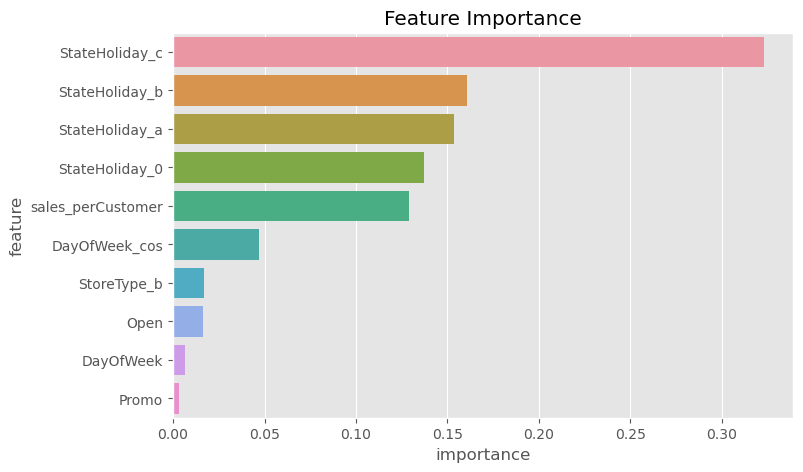

In [155]:
#Important features according to the XGBoost model.
plt.figure(figsize=(8,5))
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xg_cl.feature_importances_
}).sort_values('importance', ascending=False)
plt.title('Feature Importance')
sns.barplot(data=feature_importance_df.head(10), x='importance', y='feature');

In [143]:
test = pd.concat([X_test1['Date'],y_test],axis=1)
test['Actual']  = np.expm1(test['Sales_norm'])
test['Predictions'] = y_pred_xg
test.drop('Sales_norm',axis=1,inplace=True)
test

,Date,Actual,Predictions
169265,2015-03-02,10943.00000,10568.56250
169264,2015-03-02,7328.00000,7967.82715
169263,2015-03-02,9042.00000,9345.01172
169262,2015-03-02,11318.00000,11448.93555
169261,2015-03-02,3829.00000,3970.79712
...,...,...,...
4,2015-07-31,4821.00000,5625.41211
3,2015-07-31,13994.00000,13672.53125
2,2015-07-31,8313.00000,9229.26758
1,2015-07-31,6063.00000,7152.21094


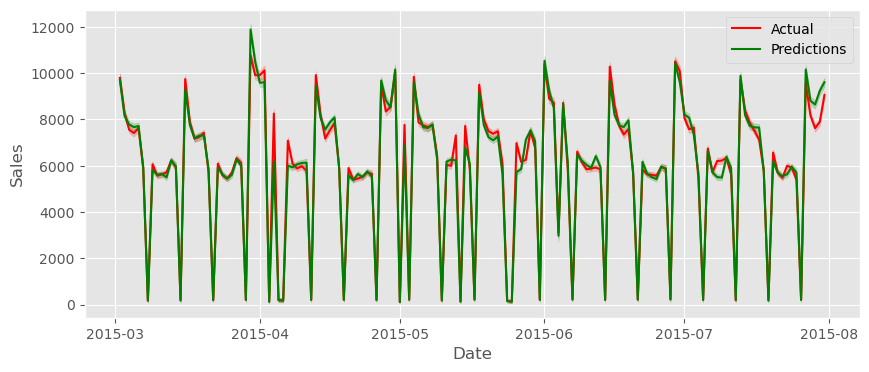

In [148]:
#Comparision of Actual and Predicted Sales on testdata from XGBoost model.
plt.figure(figsize=(10,4))
#sns.set_palette("husl")
ax = sns.lineplot(x = 'Date', y='value', hue='variable', data = pd.melt(test, ['Date']),palette=['r','g'])
ax.set(ylabel='Sales')
plt.legend()
plt.show()

From the above graph we can see that there is minimal error between Actual Sales and Predictions